## Model evaluation

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite
using TransformersLite

In [ ]:
includet("reporting.jl")
includet("training.jl")

In [ ]:
nlabels = 5

5

## Load data

raw

In [ ]:
path = path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [ ]:
directory = "../outputs/20220519_1829"

saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => BytePairEncoder{String}(length(rules)=8000, length(cache)=0, un…
  :indexer   => IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
@show tokenizer = saved_objects[:tokenizer]
@show indexer = saved_objects[:indexer]
model = saved_objects[:model]
display(model)

tokenizer = saved_objects[:tokenizer] = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = saved_objects[:indexer] = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.0),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.0),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.0),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 5),                       # 255 parameters
)        # Total: 21 trainable arrays, 251_552 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.083 MiB.

In [ ]:
max_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 52.043689 seconds (654.73 M allocations: 20.558 GiB, 8.87% gc time, 1.11% compilation time)
 22.578522 seconds (133.27 k allocations: 84.891 MiB, 0.41% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [ ]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.703472 seconds (6.00 M allocations: 210.075 MiB, 4.56% gc time, 14.25% compilation time)
  0.525044 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=64, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=64, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

 70.180576 seconds (37.99 M allocations: 57.008 GiB, 8.98% gc time, 21.66% compilation time)


0.5590944444444444

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  5.202943 seconds (65.44 k allocations: 6.116 GiB, 9.01% gc time)


0.50125

In [ ]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[1.2464, 1.16366, 1.12826, 1.10525, 1.07972, 1.07246, 1.05…
  "train_acc"  => Any[0.44615, 0.486828, 0.504689, 0.517039, 0.528689, 0.530672…
  "val_acc"    => Any[0.44425, 0.4787, 0.49155, 0.4957, 0.5044, 0.50365, 0.5059…
  "val_loss"   => Any[1.25654, 1.18716, 1.16427, 1.15183, 1.13449, 1.14394, 1.1…

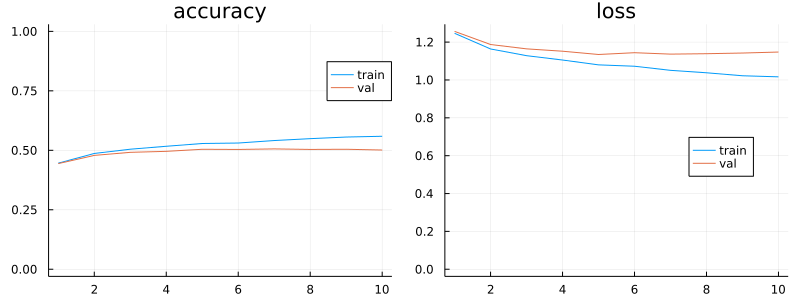

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.4924

In [ ]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [ ]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 725  154   72   12   37
 352  285  255   60   48
 157  206  369  201   67
  41   66  259  384  250
  29   26   40  206  699

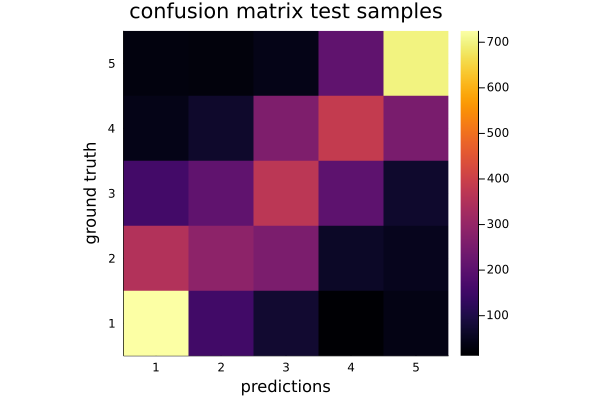

In [ ]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
savefig(p, joinpath(directory, "confusion_matrix.png"))
p

In [ ]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.56    0.72      0.63     1000
           2       0.39    0.28      0.33     1000
           3       0.37    0.37      0.37     1000
           4       0.44    0.38      0.41     1000
           5       0.63    0.70      0.67     1000

weighted avg       0.48    0.49      0.48     5000

In [ ]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    println(" idx  y  ŷ ")
    for idx in sample(idxs_wrong, nshow, replace=false)
        @printf("%4d  %d  %d  %s\n\n",
            idx, labels_test[idx], y_pred[idx], documents_test[idx]
        )
    end
end


true label = 1
#incorrect 275
 idx  y  ŷ 
 355  1  3  Took a bottle to Prague with me but it just did not seem to do much.

 284  1  2  Nice style, but quality is too low! It simply fell apart! And I just tried it on, didn't have time to wear


true label = 2
#incorrect 715
 idx  y  ŷ 
1958  2  3  The shoes are decent, mine came damaged as well as the packaging being damaged but I need should now and can't replace them. I'd recommend a different brand honestly.

1913  2  1  I wanted to like this movie because of the important and meaningful context of child abduction, but I couldn't watch the whole thing, I had to start skipping parts due to the main character not being likable, lots of flash editing transitions that you can do in imovie, and just drawn out redundant scenes. If you want to watch an unforgettable similar movie, try "Dearest" - best child abduction and Chinese movie I've seen..


true label = 3
#incorrect 631
 idx  y  ŷ 
2462  3  1  This is way overpriced. It's literall

## Probabilities for all labels

In [ ]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9742  This is THE BEST mascara I have found. I live in south Florida and this stays on through humidity, rain, everything and NO clumping or smudging. It's buildable and really easy to remove. LOVE IT!

   4  3  4  0.9270  I rated this dress as only 3 stars because it doesn't have a zipper or velcro in the back and it's difficult for my 4 y.o. to get on. We have purchased the Princess Belle dress from this company and loved it because it has a zipper on the back and is so easy to get on. Because it's difficult for my daughter to pull on, she tends to not play with it nearly as much as her other dresses. Otherwise, it's a beautiful dress and seems to be good quality, I just wish she was able to get into it easier.

   3  3  3  0.8137  OK for the price but the lights that the description says it has either do not exist or do not work. the charger part itself works though so i did not bother to call and complain

   2  2  2  0.6592  Great seat however mine 

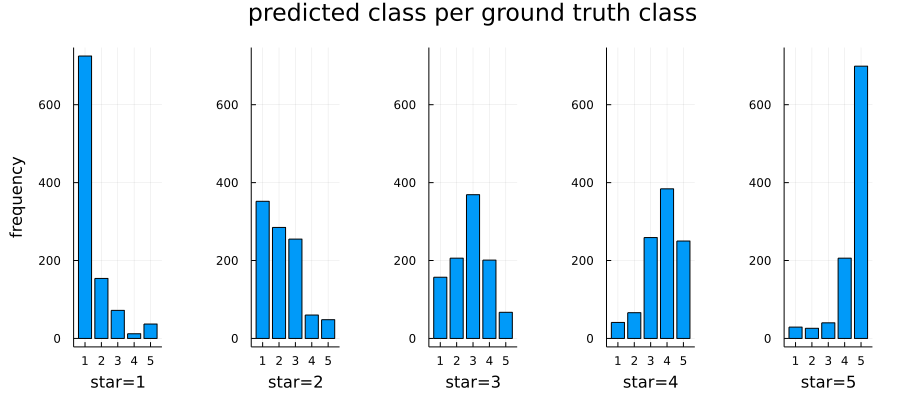

In [ ]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "prediction_star.png"))
p

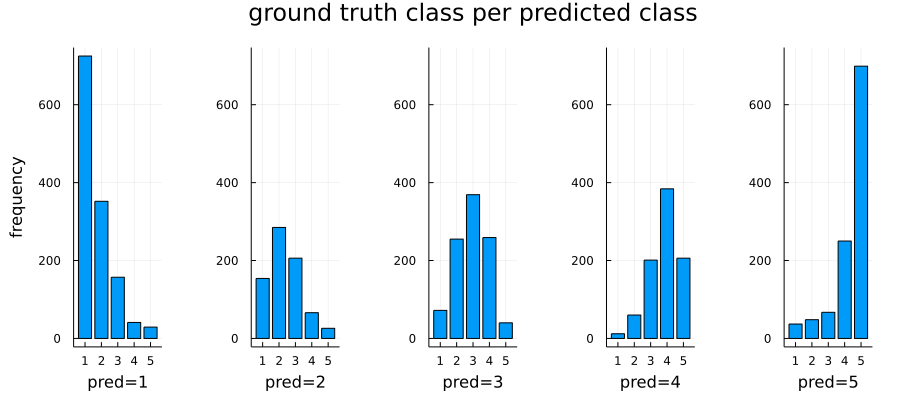

In [ ]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "star_prediction.png"))
p

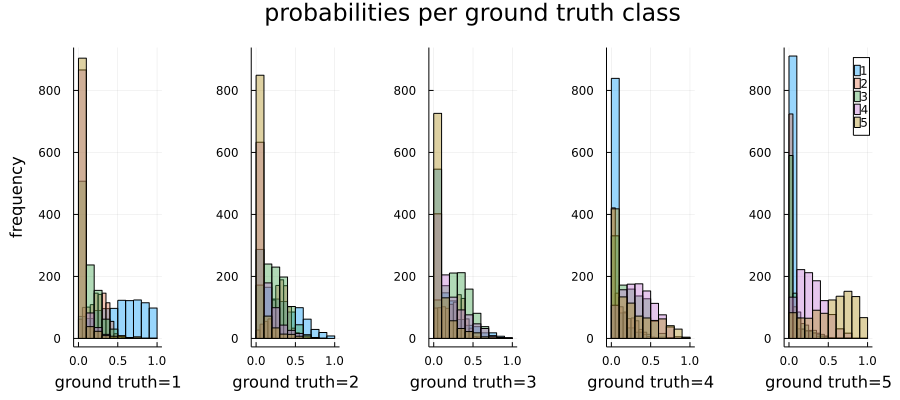

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star.png"))
p

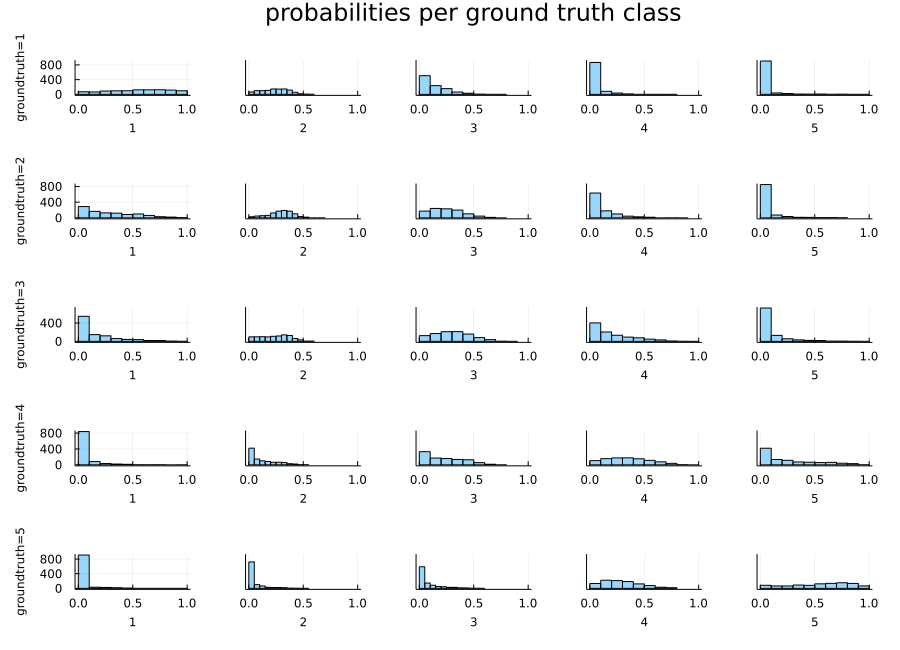

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star_grid.png"))
p

## Single sample

In [ ]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !
⋅used|⋅for|⋅party|⋅and|⋅was|⋅great
89|7|805|4|14|29|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
  0.268947  -1.44952    0.395593   …  -1.2528     -1.2528     -1.2528
  0.31001    0.292046   0.222907       0.156757    0.156757    0.156757
 -1.80284   -0.870793   0.119598      -0.26365    -0.26365    -0.26365
  1.50219    2.54521   -0.991652      -0.594382   -0.594382   -0.594382
 -0.600103  -0.321729  -0.0685164     -0.212088   -0.212088   -0.212088
  0.734541  -0.366851   1.30724    …  -0.527715   -0.527715   -0.527715
  0.145128   1.70155   -0.15033       -1.01218    -1.01218    -1.01218
  1.4403    -1.3517    -0.0401051      0.790769    0.790769    0.790769
  1.52516   -0.564732  -2.30472       -0.801092   -0.801092   -0.801092
  0.033799  -1.83414    0.284791      -0.343969   -0.343969   -0.343969
 -0.534375  -0.862029   1.60413    …  -0.664029   -0.664029   -0.664029
 -1.01483    0.698094   1.2683        -0.114161   -0.114161   -0.114161
 -0.280347   0.125022   0.646837      -0.200114   -0.200114   -0.200114
  ⋮                                ⋱         

In [ ]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.001988721
 0.0046583456
 0.018931871
 0.33414483
 0.6402762